# Live demo at EuroPython 2018

Goals

* Take live survey data from the audience about Ada's weight
* Provide descriptive statistics
* Graph the two surveys
* See if the sample variance changes when more information is provided

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from utility import fetch

In [7]:
CSV_FILENAME_1 = "survey1_europython.csv"
CSV_FILENAME_2 = "survey2_europython.csv" 
OFFSET = 85 # to jump past the previous iteration's answers

# faked data files in case we have wi-fi issues
#CSV_FILENAME_1 = "survey1_pylondinium.csv"
#CSV_FILENAME_2 = "survey2_pylondinium.csv"
#OFFSET = 0
#CSV_FILENAME_1 = "survey1_fake.csv"
#CSV_FILENAME_2 = "survey2_fake.csv" 

In [8]:
if False:
    EXPERIMENT_1 = "Ian's Keynote Experiment (part 1) (Responses)"
    EXPERIMENT_2 = "Ian's Keynote Experiment (part 2) (Responses)" 

    # only fetch during the live demo
    fetch(EXPERIMENT_1, CSV_FILENAME_1)
    fetch(EXPERIMENT_2, CSV_FILENAME_2)

In [9]:
# load the data
def load_data(filename):
    df_raw = pd.read_csv(filename)
    df = df_raw.set_index(pd.to_datetime(df_raw.Timestamp))
    df = df.drop(columns=['Timestamp'])
    df.columns = ['answer']

    def convert(s):
        """Super dumb & robust method to drop anything that might not process"""
        result = None
        try:
            result = float(s)
        except ValueError:
            pass
        return result

    ser = df.answer.apply(convert)
    ser = ser.dropna()
    return ser

In [10]:
assert os.path.exists(CSV_FILENAME_1), "We're missing our data!"

## Experiment 1

In [11]:
ser_poor = load_data(CSV_FILENAME_1)
ser_poor = ser_poor[OFFSET:]
pd.DataFrame(ser_poor).head()

,answer
Timestamp,
2018-10-06 10:10:39,14.0
2018-10-06 10:12:01,14.0
2018-10-06 10:12:39,4.0
2018-10-06 10:12:47,13.0
2018-10-06 10:12:52,15.0


In [12]:
ser_poor.describe()

count    476.000000
mean            inf
std             NaN
min      -15.000000
25%        8.000000
50%       13.000000
75%       20.000000
max             inf
Name: answer, dtype: float64

In [13]:
def drop_nan_inf(ser):
    return ser.replace([np.inf, -np.inf], np.nan).dropna()

ser_poor = drop_nan_inf(ser_poor)
ser_poor.describe()

count     4.750000e+02
mean     4.210526e+103
std      6.482008e+104
min      -1.500000e+01
25%       8.000000e+00
50%       1.300000e+01
75%       2.000000e+01
max      1.000000e+106
Name: answer, dtype: float64

Note the wider distribution and less-well-defined mean estimate.

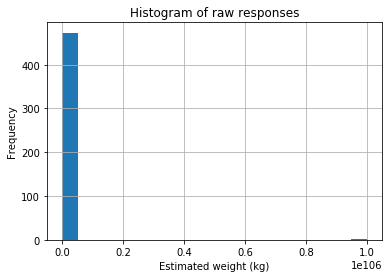

In [14]:
ax = ser_poor.hist(bins=20);
ax.set_title("Histogram of raw responses")
ax.set_ylabel("Frequency")
ax.set_xlabel("Estimated weight (kg)");

In [15]:
max_weight = 80
bins = range(0, max_weight, 2)

def mask_and_descriptive_statistics(ser):
    mask = (ser >= 1) & (ser <= max_weight)

    ser_clipped = ser[mask]
    mean = ser_clipped.mean()
    median = ser_clipped.median()
    lower_quantile = ser_clipped.quantile(q=0.05)
    upper_quantile = ser_clipped.quantile(q=0.95)
    return ser_clipped, mean, median, lower_quantile, upper_quantile, bins

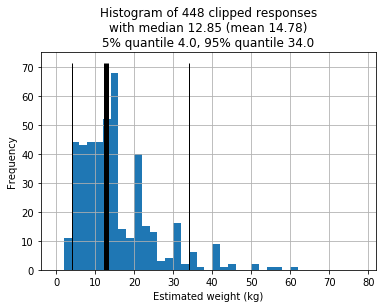

In [16]:
def draw_clipped_distribution(ser):
    ser_clipped, mean, median, lower_quantile, upper_quantile, bins = mask_and_descriptive_statistics(ser)
    ax = ser_clipped.hist(bins=bins)
    title = f"Histogram of {ser_clipped.shape[0]} clipped responses\nwith median {median:0.2f} (mean {mean:0.2f})"
    title += f"\n5% quantile {lower_quantile}, 95% quantile {upper_quantile}"
    ax.set_title(title)
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Estimated weight (kg)");
    ymax = ax.get_ylim()[1]
    ax.vlines(median, ymin=0, ymax=ymax, linewidth=5)
    ax.vlines(lower_quantile, ymin=0, ymax=ymax, linewidth=1)
    ax.vlines(upper_quantile, ymin=0, ymax=ymax, linewidth=1);
    return ser_clipped
    
ser_poor_clipped = draw_clipped_distribution(ser_poor)

## Experiment 2 (with better information)

In [17]:
ser_good = load_data(CSV_FILENAME_2)
ser_good = ser_good[OFFSET:]
ser_good = drop_nan_inf(ser_good)
pd.DataFrame(ser_good).describe()

,answer
count,4.220000e+02
mean,2.369668e+08
std,4.867924e+09
min,-9.990000e+02
25%,8.000000e+00
50%,1.200000e+01
75%,1.500000e+01
max,1.000000e+11


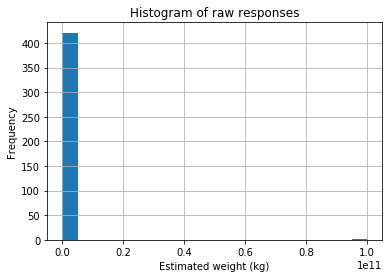

In [18]:
ax = ser_good.hist(bins=20);
ax.set_title("Histogram of raw responses")
ax.set_ylabel("Frequency")
ax.set_xlabel("Estimated weight (kg)");

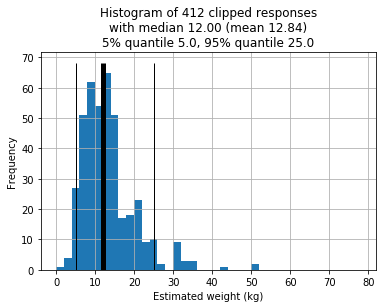

In [19]:
ser_good_clipped = draw_clipped_distribution(ser_good)

# Combine the two results raw (non-trimmed) results

In [20]:
df2 = pd.DataFrame()
df2['estimates_poor'] = ser_poor_clipped.reset_index(drop=True)
df2['estimates_good'] = ser_good_clipped.reset_index(drop=True)
df2.head()

,estimates_poor,estimates_good
0,14.0,15.00000
1,14.0,30.00000
2,4.0,18.71337
3,13.0,8.00000
4,15.0,7.00000


In [21]:
df2.tail()

,estimates_poor,estimates_good
443,25.0,NaN
444,12.0,NaN
445,10.0,NaN
446,14.3,NaN
447,35.0,NaN


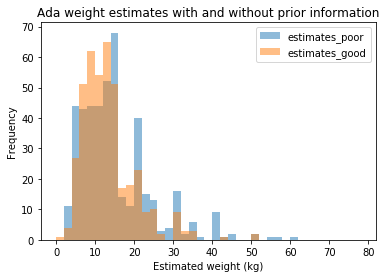

In [22]:
ax = df2.plot(kind="hist", alpha=0.5, bins=bins);
ax.set_xlabel("Estimated weight (kg)")
ax.set_title("Ada weight estimates with and without prior information");

**True weight** == 17kg (she's heavier than she looks!)

**Caveat** the above assumes we had an fairly _equal_ count of guesses in both files, otherwise we'll have a bias that might change how we perceive the result

# Prettier Plot.ly plots

In [23]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Histogram(x=ser_poor, 
                     opacity=0.6,
                     name="estimates_poor"),
        go.Histogram(x=ser_good, 
                     opacity=0.6,
                     name="estimates_good")]

layout = go.Layout(
    autosize=False,
    width=500,
    height=500,
    title="Estimating Ada's weight using Plot.ly",
    xaxis=dict(range=[0, 60], title="Estimated weight kilograms"),
    yaxis=dict(title="Frequency of binned guess"),
    barmode='overlay'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="keynotedemo")